In [160]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

def f(X, theta):
    return X @ theta

def loss(theta, X, y):
    y_pred = f(X, theta)
    error = np.square(y_pred - y)
    return np.mean(error)

def grad_loss(theta, X, y):
    y_pred = f(X, theta)
    return (2 / len(y)) * X.T @ (y_pred - y)

def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch

        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [161]:
# Split data into training and testing
def split_data(X, y):
    d, N = X.shape
    N_train = int(0.8 * d)
    idx = np.arange(d)
    np.random.shuffle(idx)

    train_idx = idx[:N_train]
    test_idx = idx[N_train:]

    X_train = X[train_idx, :]
    Y_train = y[train_idx]
    X_test = X[test_idx, :]
    Y_test = y[test_idx]


    return (X_train, Y_train), (X_test, Y_test)

In [162]:
# Load data
data = pd.read_csv("poly_regression_large.csv")
x, y = data["x"].values, data["y"].values

# define k for polynomial
K = 5

In [163]:
# Define the Vandermonde matrix
def vandermonde(x, K):
    N = len(x)
    PhiX = np.zeros((N, K))
    for i in range(K):
        PhiX[:, i] = x**i
    return PhiX   

In [164]:
# Testing Data
phiX = vandermonde(x, K)

# Split the data and only retain test data
(train_X, train_y), (test_X, test_y) = split_data(phiX, y)

# Training Data
data_small = pd.read_csv("./poly_regression_small.csv")
x_small, y_small = data_small["x"].values, data_small["y"].values

# Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
phiX_small = vandermonde(x_small, K)

In [165]:
# initialize infos
theta0 = np.zeros(K)
alpha = 0.1
batch_size = 5
n_epochs = 500

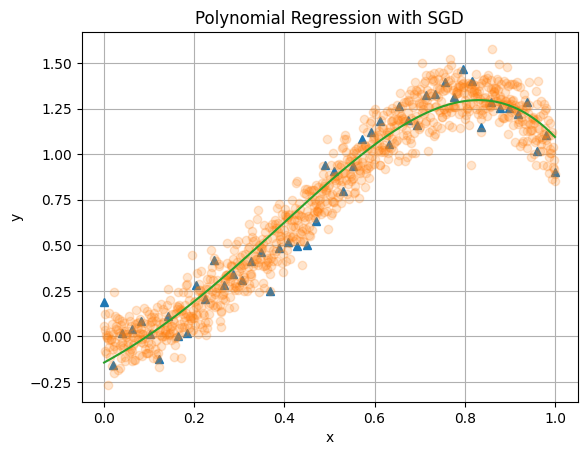

In [166]:
# Train SGD model with small data
theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD(loss, grad_loss, (phiX_small, y_small), theta0, alpha, batch_size, n_epochs)

# Test the model
test_loss_sgd = loss(theta_history_sgd[-1], test_X, test_y)

plt.plot(x_small, y_small, '^')
plt.plot(x, y, 'o', alpha=0.2)
plt.plot(x, f(phiX, theta_history_sgd[-1]))
plt.title("Polynomial Regression with SGD")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [167]:
# Train the polynomial regression model on the training set via the Gradient Descent algorithm.
def GD(f, grad_f, x0, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    # initialize the infos
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))

    # set the values for infos for x0
    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0))
    xk = x0
    for k in range(maxit):
        x = xk - alpha * grad_f(xk)

        # Update the infos
        f_val[k+1] = f(x)
        grad_norm[k+1] = np.linalg.norm(grad_f(x))

        if grad_norm[k+1] <= tolf * grad_norm[0] or np.linalg.norm(x - xk) <= tolx:
            break
        xk = x
    
    # cut off exceeding values
    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]

    return x, k, f_val, grad_norm

[-0.14166589  1.67815183  0.80503711 -0.18907202 -0.95263693]


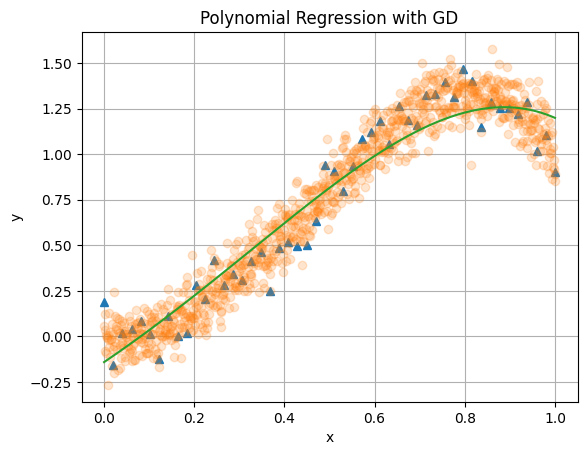

In [168]:
# Loss and gradient function for GD
def f_loss(theta):
    return loss(theta, phiX_small, y_small)

def f_grad_loss(theta):
    return grad_loss(theta, phiX_small, y_small)

# Train GD model
x_sol, b, f_val, grad_norm = GD(f_loss, f_grad_loss, theta0, alpha=0.08)

# Test the model
test_loss_gd = loss(x_sol, test_X, test_y)

print(x_sol)

# Plot the result
plt.plot(x_small, y_small, '^')
plt.plot(x, y, 'o', alpha=0.2)
plt.plot(x, f(phiX, x_sol), '-')
plt.title("Polynomial Regression with GD")
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
plt.show()

In [169]:
def ne_cholesky(X, y):
    A = X.T @ X
    b = X.T @ y

    R = np.linalg.cholesky(A)

    alphaNE = np.linalg.solve(R, b)

    thetaNE = np.linalg.solve(R.T, alphaNE)

    return thetaNE

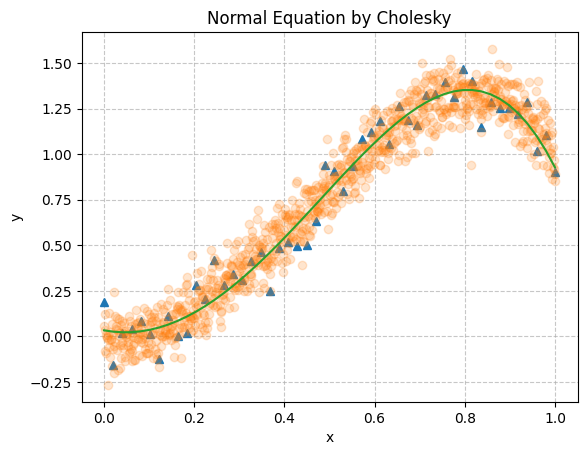

In [170]:
thetaNE = ne_cholesky(phiX_small, y_small)

# Visualize the noisy data
plt.plot(x_small, y_small, '^')
plt.plot(x, y, 'o', alpha=0.2)
plt.plot(x_small, f(phiX_small, thetaNE), '-')
plt.title("Normal Equation by Cholesky")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

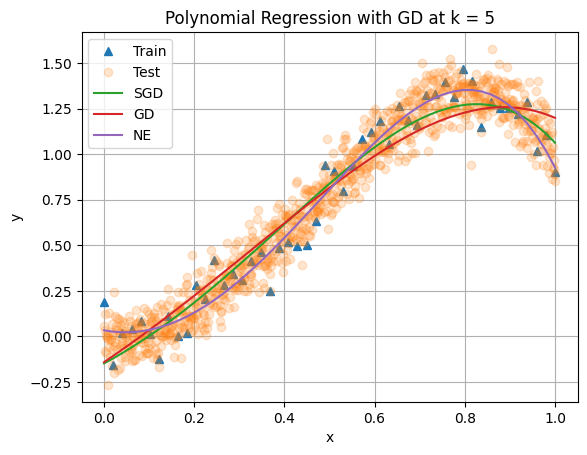

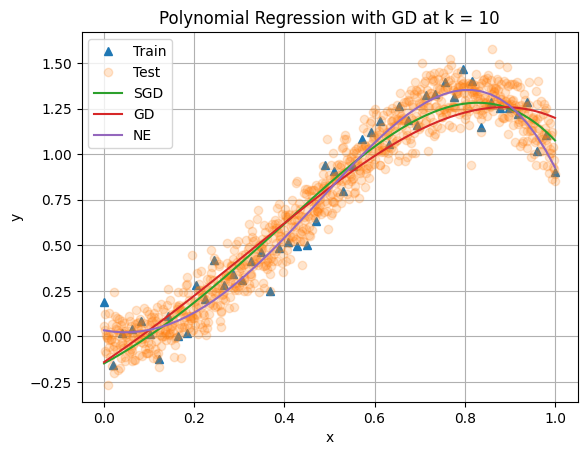

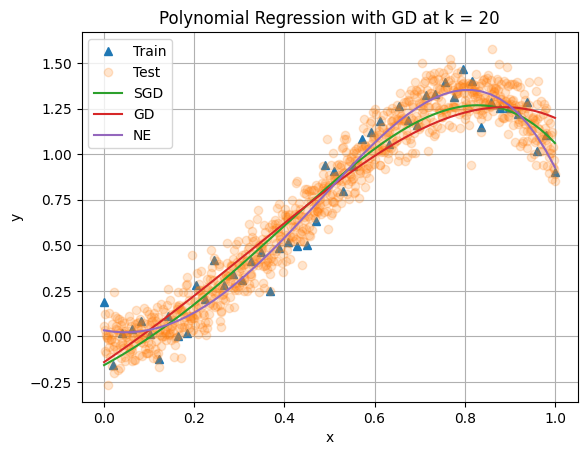

In [171]:
# For different values of k, plot the training datapoints and the test datapoints with different colors and visualize (as a continuous line) the three learned regression model
K_vals = [5, 10, 20]
theta_true_k5 = np.array([0, 0, 4, 0, -3]) 

for k in K_vals:
    # Testing Data
    phiX = vandermonde(x, K)

    # Split the data and only retain test data
    (train_X, train_y), (test_X, test_y) = split_data(phiX, y)

    # Training Data
    data_small = pd.read_csv("./poly_regression_small.csv")
    x_small, y_small = data_small["x"].values, data_small["y"].values

    # Train the polynomial regression model on the training set via the Stochastic Gradient Descent algorithm
    phiX_small = vandermonde(x_small, K)

    # Train SGD model with small data
    theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD(loss, grad_loss, (phiX_small, y_small), theta0, alpha, batch_size, n_epochs)

    # Test the model
    test_loss_sgd = loss(theta_history_sgd[-1], test_X, test_y)

    # Train GD model
    x_sol, b, f_val, grad_norm = GD(f_loss, f_grad_loss, theta0, alpha=0.08)

    # Test the model
    test_loss_gd = loss(x_sol, test_X, test_y)

    # Normal Equation with Cholesky
    thetaNE = ne_cholesky(phiX_small, y_small)

    # Plot the result
    plt.plot(x_small, y_small, '^')
    plt.plot(x, y, 'o', alpha=0.2)
    plt.plot(x, f(phiX, theta_history_sgd[-1]), '-')
    plt.plot(x, f(phiX, x_sol), '-')
    plt.plot(x_small, f(phiX_small, thetaNE), '-')
    plt.title(f"Polynomial Regression with GD at k = {k}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(['Train','Test','SGD', 'GD', "NE"])
    plt.grid()
    plt.show()

    # plt.plot(loss_history_sgd)
    # plt.plot(f_val)
    # plt.xlabel("Epochs")
    # plt.ylabel("Loss")
    # plt.legend(['SGD', 'GD'])
    # plt.show()

In [172]:
# loss function for MAP
def loss_map(theta, X, y, lam):
    mle = loss(theta, X, y)

    map = 0.5 * lam * np.sum(theta**2)
    return mle + map

# grad of loss for MAP
def grad_loss_map(theta, X, y, lam):
    grad_mse = grad_loss(theta, X, y)
    
    grad_map = lam * theta
    return grad_mse + grad_map

In [173]:
def SGD_MAP(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, lam):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch

        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch, lam)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y, lam)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [174]:
def f_loss_map(theta, lam):
    return loss_map(theta, phiX_small, y_small, lam)

def f_grad_loss_map(theta, lam):
    return grad_loss_map(theta, phiX_small, y_small, lam)

In [175]:
# Train the polynomial regression model on the training set via the Gradient Descent algorithm.
def GD_MAP(f, grad_f, x0, alpha, lam, maxit=1000, tolf=1e-6, tolx=1e-6):
    # initialize the infos
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))

    # set the values for infos for x0
    f_val[0] = f(x0, lam)
    grad_norm[0] = np.linalg.norm(grad_f(x0, lam))
    xk = x0
    for k in range(maxit):
        x = xk - alpha * grad_f(xk, lam)

        # Update the infos
        f_val[k+1] = f(x, lam)
        grad_norm[k+1] = np.linalg.norm(grad_f(x, lam))

        if grad_norm[k+1] <= tolf * grad_norm[0] or np.linalg.norm(x - xk) <= tolx:
            break
        xk = x
    
    # cut off exceeding values
    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]

    return x, k, f_val, grad_norm

In [176]:
def ne_cholesky_map(X, y, lam):
    A = X.T @ X + lam * np.eye(phiX_small.shape[1])
    b = X.T @ y

    R = np.linalg.cholesky(A)

    alphaNE = np.linalg.solve(R, b)

    thetaNE = np.linalg.solve(R.T, alphaNE)

    return thetaNE

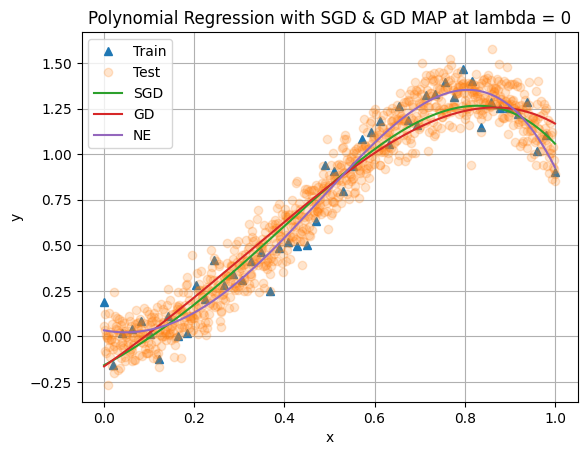

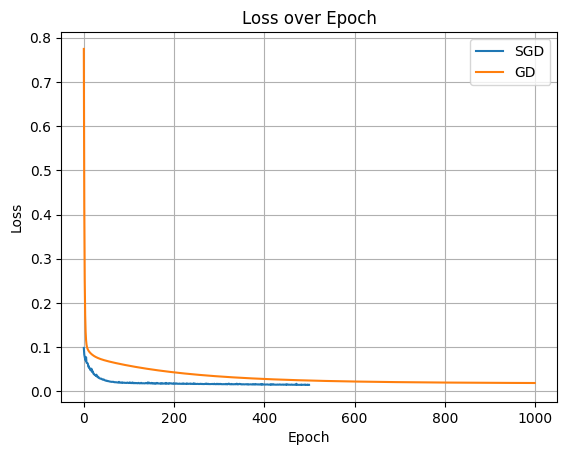

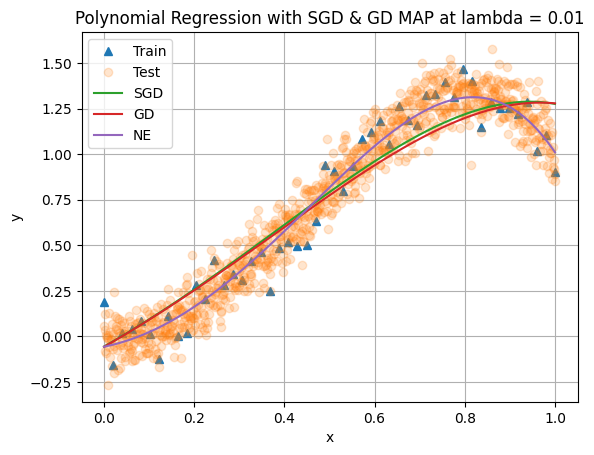

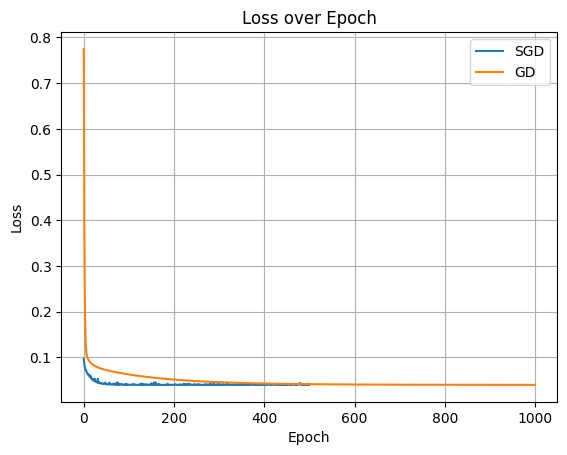

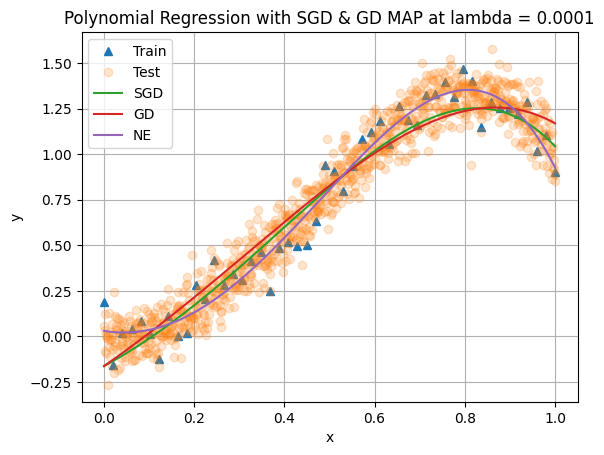

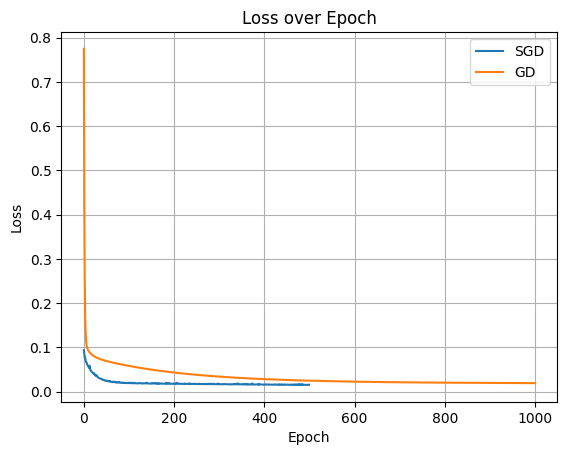

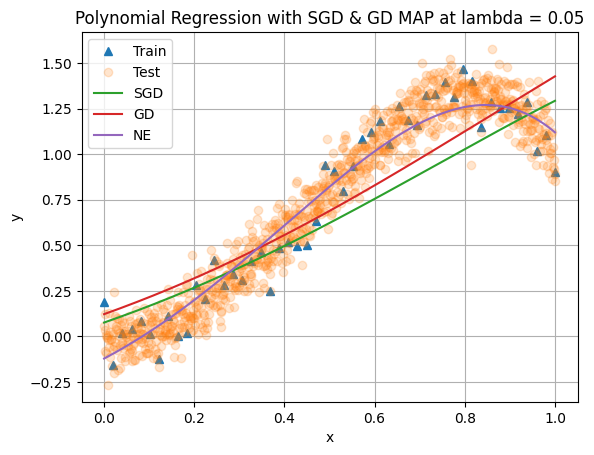

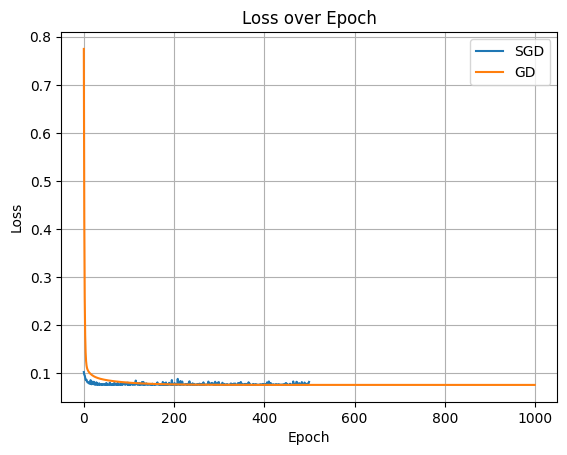

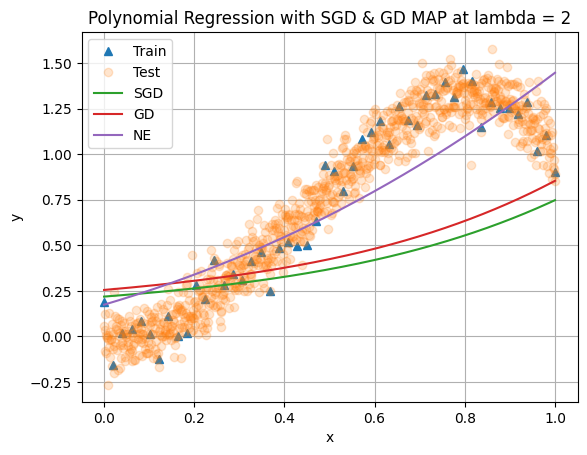

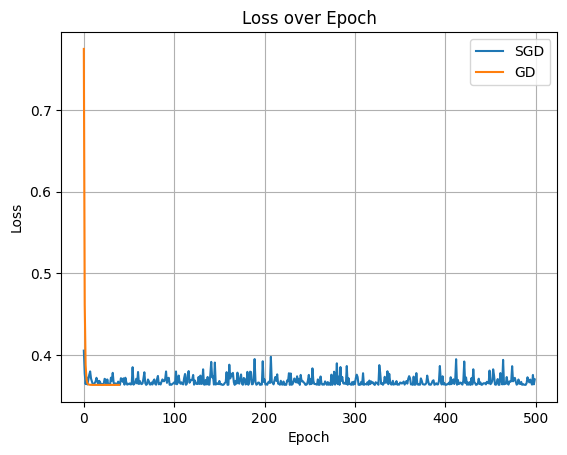

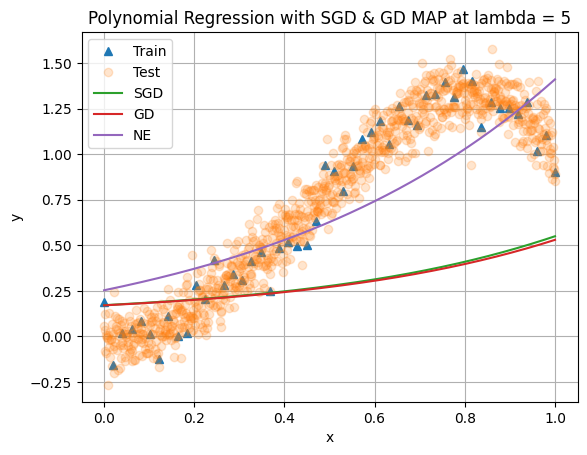

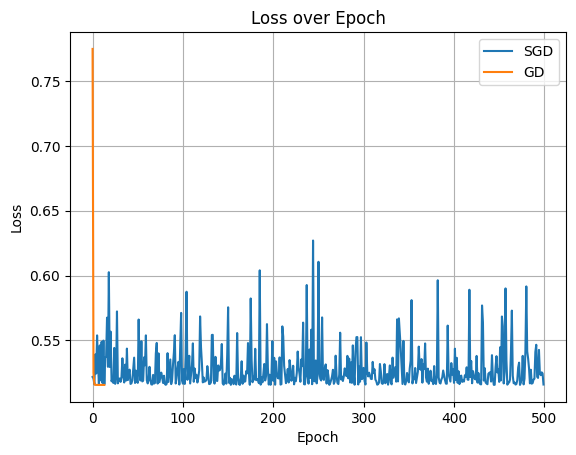

In [179]:
k = 8

lam_vals = [0, 0.01, 0.0001, 0.05, 2, 5]


for lam in lam_vals:
    # Train SGD model with small data
    theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD_MAP(loss_map, grad_loss_map, (phiX_small, y_small), theta0, alpha, batch_size, n_epochs, lam)

    # Test the model
    test_loss_sgd = loss(theta_history_sgd[-1], test_X, test_y)
    all_theta_history_sgd = theta_history_sgd[-1]

    # Train GD model
    x_sol, b, f_val, grad_norm = GD_MAP(f_loss_map, f_grad_loss_map, theta0, alpha, lam)

    # Test the model
    test_loss_gd = loss(x_sol, test_X, test_y)

    # Test with Normal Equation
    thetaNE = ne_cholesky_map(phiX_small, y_small, lam)

    # # Plot the result
    plt.plot(x_small, y_small, '^')
    plt.plot(x, y, 'o', alpha=0.2)
    plt.plot(x, f(phiX, theta_history_sgd[-1]), '-')
    plt.plot(x, f(phiX, x_sol), '-')
    plt.plot(x, f(phiX, thetaNE), '-')
    plt.title(f"Polynomial Regression with SGD & GD MAP at lambda = {lam}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend(['Train','Test','SGD', 'GD', 'NE'])
    plt.grid()
    plt.show()  

    plt.plot(loss_history_sgd)
    plt.plot(f_val)
    plt.title(f"Loss over Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(['SGD','GD'])
    plt.grid()
    plt.show()  